<a href="https://colab.research.google.com/github/marcuuus/AMD-SM2L-20-21-RIVA/blob/main/project_RIVA_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOAD OF THE DATASET.

In [1]:
!mkdir /root/.kaggle

In [2]:
!echo '{"username":"marcuus96","key":"ca8a06de4d10013b1a150c0e7026cf37"}' > /root/.kaggle/kaggle.json

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download jeffheaton/glasses-or-no-glasses

100% 6.11G/6.11G [02:18<00:00, 60.3MB/s]
100% 6.11G/6.11G [02:18<00:00, 47.4MB/s]


In [5]:
!unzip /content/glasses-or-no-glasses.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: faces-spring-2020/faces-spring-2020/face-1000.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1001.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1002.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1003.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1004.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1005.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1006.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1007.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1008.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1009.png  
  inflating: faces-spring-2020/faces-spring-2020/face-101.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1010.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1011.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1012.png  
  inflating: faces-spring-2020/faces-spri

DATASET PREPARATION AND DATA CLEANING.

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from matplotlib import pyplot as plt
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import itertools
from IPython.display import display, Javascript, clear_output, HTML

from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint

The test set doesn't have a label associated to the image, so the first thing to do is create one for all the test images.

The second thing to do is check the correcteness of the labels in the train set. I noticed that some labels in the train set are wrong, so I checked by hand if each label was right. I created a text file with the new labels, named label_train.txt (attached in the github repository), and I uploaded it in the notebook. I did the same thing for the test's labels

In [7]:
!npx degit https://github.com/marcuuus/AMD-SM2L-20-21-RIVA -f

npx: installed 1 in 2.96s
> destination directory is not empty. Using --force, continuing
> cloned marcuuus/AMD-SM2L-20-21-RIVA#HEAD


In [8]:
# Creation of the test label list
with open("/content/test_labels.txt", "r") as tl:
  label_test_list = tl.readlines()
label_test_list = [x.strip() for x in label_test_list]

In [9]:
# Creation of the train label list
with open("/content/train_labels.txt", "r") as tl:
  label_train_list = tl.readlines()
label_train_list = [x.strip() for x in label_train_list]

In [10]:
# Creation of the label column named "glasses" in test.csv. a new csv file is created

def add_csv_column(csv_file, input_file):
  df = pd.read_csv(csv_file)
  df['glasses'] = input_file
  df.to_csv('/content/new_' + csv_file, float_format='%.6g', index = False)

In [11]:
add_csv_column('test.csv', label_test_list)

In [12]:
# Correction of the label column in train.csv. a new csv file is created

def modify_csv_column(csv_file, input_file):
  df = pd.read_csv(csv_file)
  
  for i in itertools.count(0):
    if i == len(input_file):
      break
    df.loc[i, 'glasses'] = input_file[i]

  df.to_csv('/content/new_' + csv_file, float_format='%.6g', index = False)

In [13]:
modify_csv_column('train.csv', label_train_list)

In [14]:
train_file_path = "/content/new_train.csv"
test_file_path = "/content/new_test.csv"

I put the images in different directories, according to the labels and the type of set

In [15]:
!mkdir /content/faces
!mkdir /content/faces/train
!mkdir /content/faces/test
!mkdir /content/faces/train/glasses
!mkdir /content/faces/train/no_glasses
!mkdir /content/faces/test/glasses
!mkdir /content/faces/test/no_glasses

In [16]:
train = pd.read_csv(train_file_path).copy()

glasses = list()
no_glasses = list()

for i,img in train.iterrows():
  if img['glasses'] == 1:
    glasses.append(int(img['id']))
  if img['glasses'] == 0:
    no_glasses.append(int(img['id']))

In [17]:
for id in glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/train/glasses')

for id in no_glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/train/no_glasses')

In [18]:
test = pd.read_csv(test_file_path).copy()

glasses = list()
no_glasses = list()

for i,img in test.iterrows():
  if img['glasses'] == 1:
    glasses.append(int(img['id']))
  if img['glasses'] == 0:
    no_glasses.append(int(img['id']))

In [19]:
for id in glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/test/glasses')

for id in no_glasses:
  os.system('mv /content/faces-spring-2020/faces-spring-2020/face-' + str(id) + '.png /content/faces/test/no_glasses')

CREATION OF THE DATASET

During the chek of the images I noticed that some of them were really ambiguous, so I remove them from the dataset. I put the label of these images to -1, so they aren't considered in the computation.

In [29]:
BATCH_SIZE = 64
EPOCHS = 10
IMG_SIZE = (160, 160)
CLASS_NAMES = ['glasses', 'no_glasses']

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def get_training_ds():
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/faces/train/',
    image_size = IMG_SIZE,
    shuffle = True,
    batch_size = BATCH_SIZE)
  dataset = dataset.cache().shuffle(1000).prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

def get_validation_ds():
  dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/faces/test/',
    image_size = IMG_SIZE,
    shuffle = True,
    batch_size = BATCH_SIZE)
  dataset = dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

EXAMPLE OF VISUALIZATION

using the train set, I visualize a list of couple (image, label)

In [22]:
ex = get_training_ds()

for example in ex.take(1):
  images, labels = example
  break

Found 4469 files belonging to 2 classes.


In [23]:
def visualize_image(images, labels, num, valid_labels):

  path = list()

  for i in itertools.count(0):
    if i == num:
      break

    else:
      image = images[i]
      label = labels[i]
      valid_label = valid_labels[i]

      if label == valid_label:
        wrong = False
      else:
        wrong = True

      path.append((image, label, wrong))
  
  y = 5
  x = int(math.ceil(len(path)/y))
  x_img = 0
  y_img =0

  f, axarr = plt.subplots(x,y, figsize=(20,20))
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=(num/5)/2.3, wspace=0.1, hspace=-0.7)
  
  for img in path:
    if x == 1:
      if img[2]:
        axarr[x_img].set_title(CLASS_NAMES[img[1]], fontsize = 20, color ='r')
      else:
        axarr[x_img].set_title(CLASS_NAMES[img[1]], fontsize = 20)

      axarr[x_img].axis("off")
      axarr[x_img].imshow(img[0].astype('uint8'))
    
    else:

      if y_img == y:
        y_img = 0
        x_img += 1

      if img[2]:
        axarr[x_img,y_img].set_title(CLASS_NAMES[img[1]], fontsize = 20, color = 'r')
      else:
        axarr[x_img,y_img].set_title(CLASS_NAMES[img[1]], fontsize = 20)

      axarr[x_img,y_img].axis("off")
      axarr[x_img,y_img].imshow(img[0].astype('uint8'))

    y_img += 1

  if (y_img-1) != (y-1):
    while(y_img != y):
      f.delaxes(axarr[x-1][y_img])
      y_img += 1


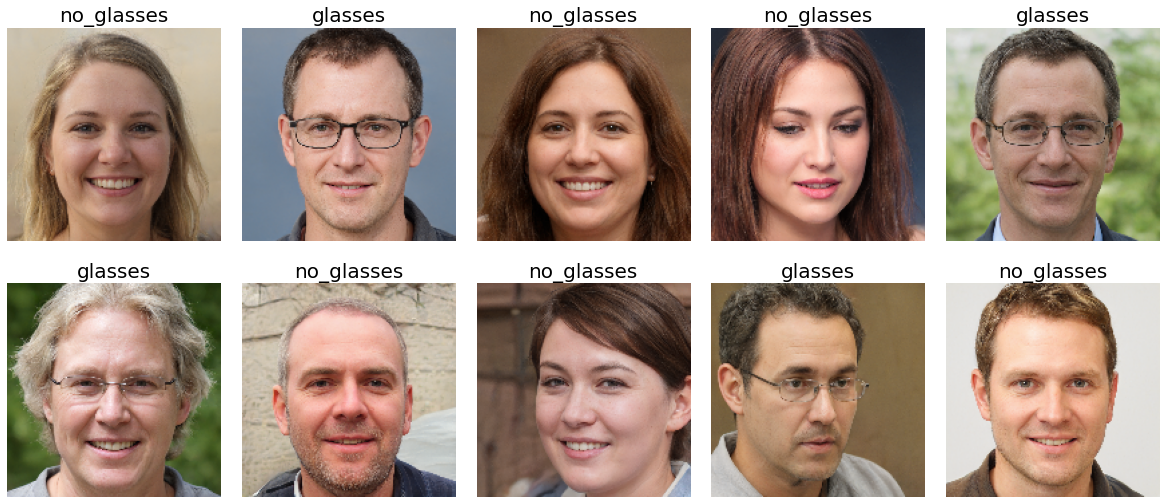

In [ ]:
visualize_image(images.numpy(), labels, 10, labels)

In [24]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 4500//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        if k=='batch' or k=='size':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)


In [25]:
def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0],
                                                                      y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display(fig)

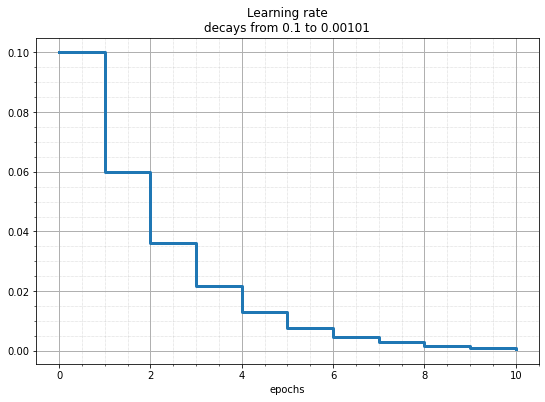

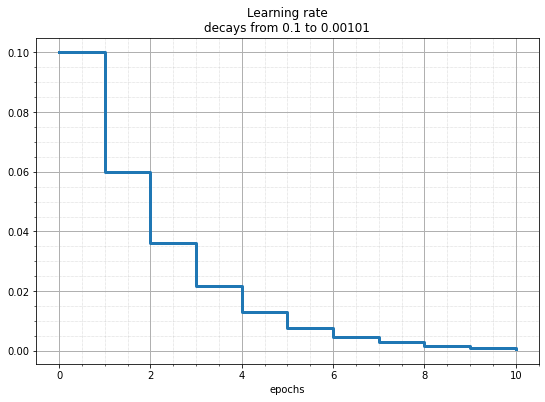

In [26]:
# lr decay function
def lr_decay(epoch):
  return 0.1 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)

plot_learning_rate(lr_decay, EPOCHS)

FIRST CNN MODEL WITH ONE CONV LAYER



In [ ]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(16, (5,5), padding='same',),
  layers.Activation('relu'),

  layers.Flatten(),

  layers.Dense(128),
  layers.Activation('relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      1216      
_________________________________________________________________
activation (Activation)      (None, 160, 160, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 409600)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               52428928  
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

next filter


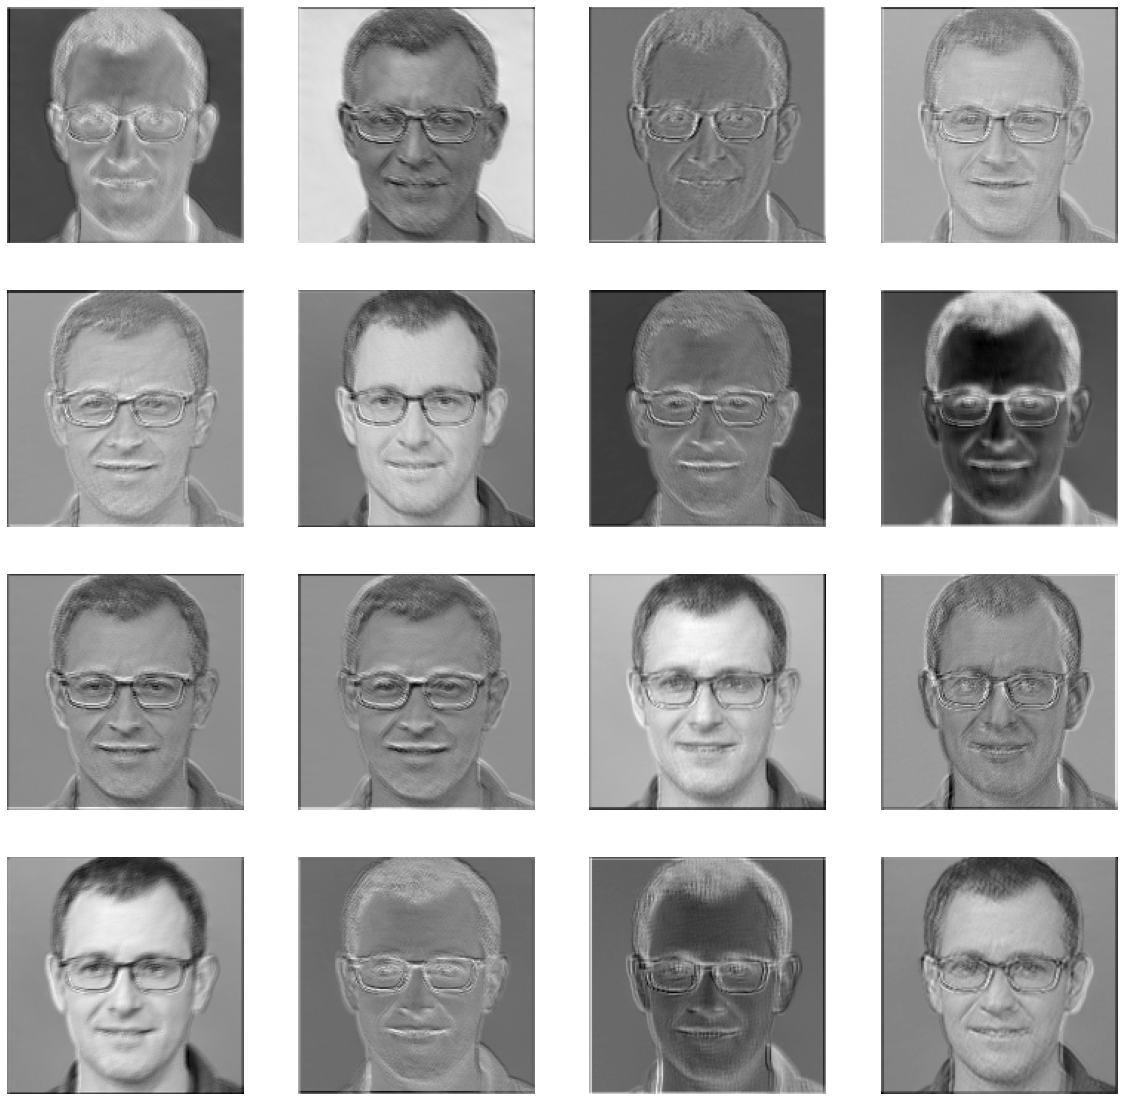

In [ ]:
#Print filters of the model

conv_list = [1]
outputs = [model.layers[x].output for x in conv_list]

model_short = tf.keras.models.Model(inputs = model.inputs, outputs = outputs)

img = np.expand_dims(images.numpy()[np.where(labels.numpy() == 0)[0][0]], axis = 0)
feature_output = model_short.predict(img)

#plot filter output

columns = 4
rows = 4
n_filters = columns * rows

for ftr in feature_output:
  print("next filter")
  fig = plt.figure(figsize=(20, 20))

  for i in range(1, n_filters + 1):
    if i > 16: break
    fig = plt.subplot(rows, columns, i)
    fig.axis('off')
    plt.imshow(ftr[:, :, i-1], cmap='gray')
  plt.show()

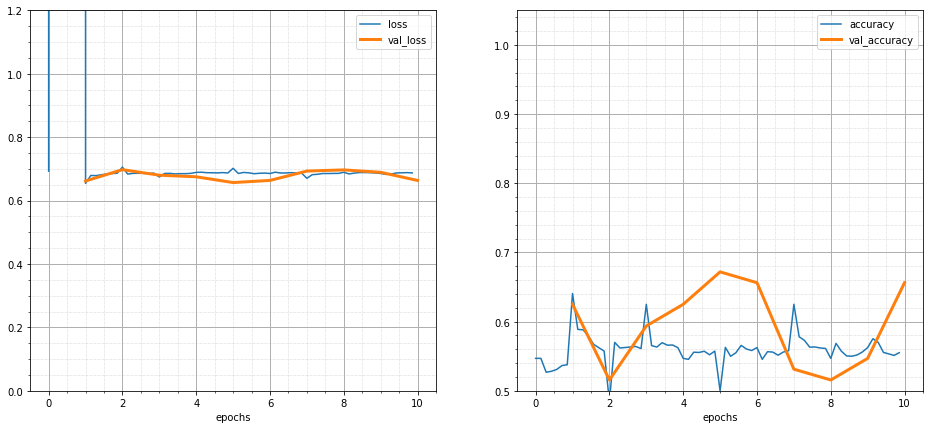

In [ ]:
training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

This network is not enough accurate. The batch normalization can improve the accuracy a lot.

ADDING BATCH NORMALIZATION

In [53]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(16, (5,5), padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),

  layers.Flatten(),

  layers.Dense(128),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_21 (Rescaling)     (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 160, 160, 16)      1216      
_________________________________________________________________
batch_normalization_63 (Batc (None, 160, 160, 16)      48        
_________________________________________________________________
activation_63 (Activation)   (None, 160, 160, 16)      0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 409600)            0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               52428928  
_________________________________________________________________
batch_normalization_64 (Batc (None, 128)             

next filter


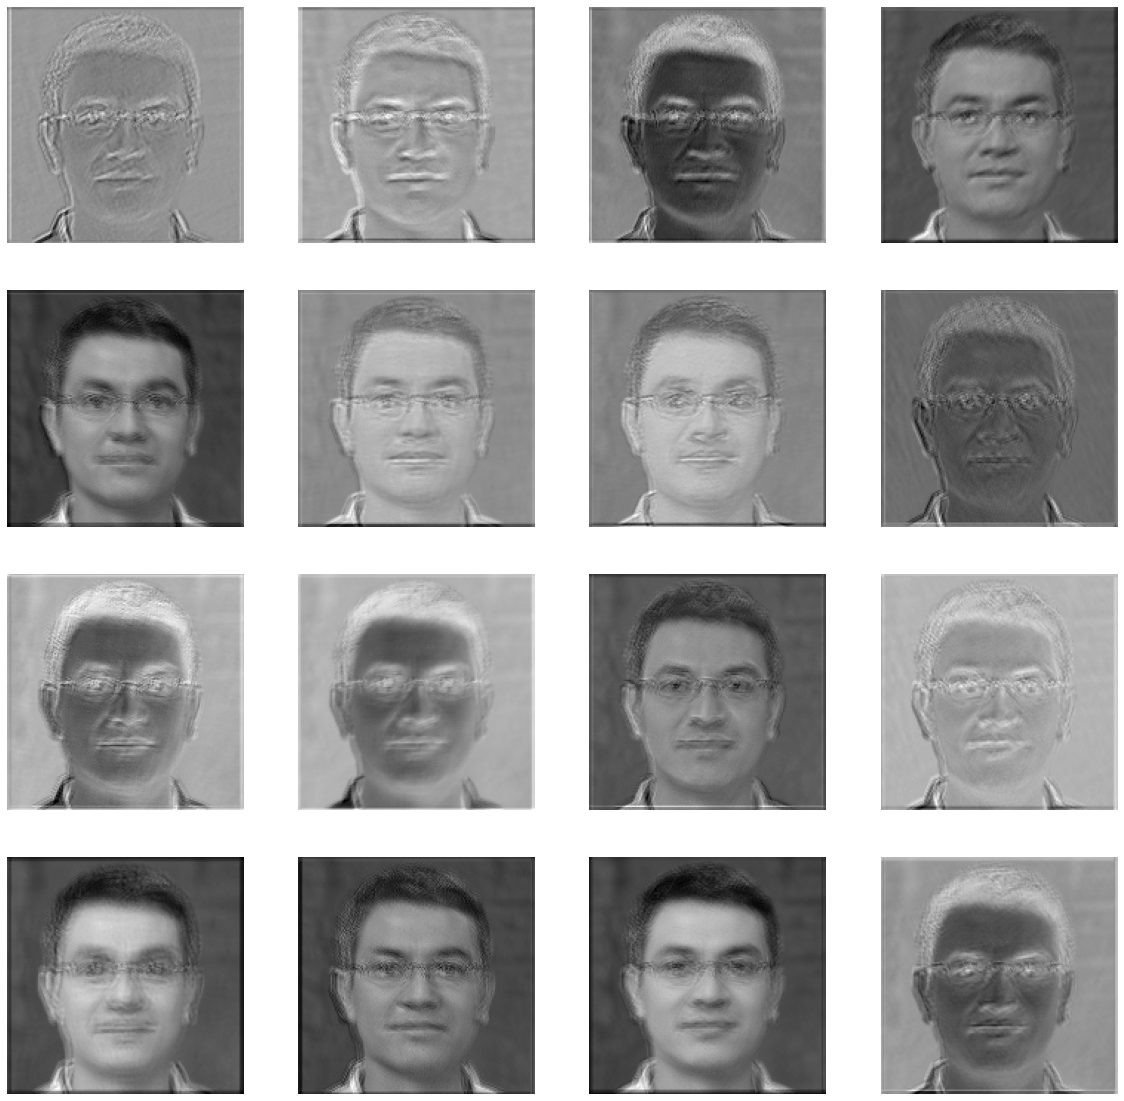

In [ ]:
#Print filters of the model

conv_list = [1]
outputs = [model.layers[x].output for x in conv_list]

model_short = tf.keras.models.Model(inputs = model.inputs, outputs = outputs)

img = np.expand_dims(images.numpy()[np.where(labels.numpy() == 0)[0][0]], axis = 0)
feature_output = model_short.predict(img)

#plot filter output

columns = 4
rows = 4
n_filters = columns * rows

for ftr in feature_output:
  print("next filter")
  fig = plt.figure(figsize=(20, 20))

  for i in range(1, n_filters + 1):
    fig = plt.subplot(rows, columns, i)
    fig.axis('off')
    plt.imshow(ftr[:, :, i-1], cmap='gray')
  plt.show()

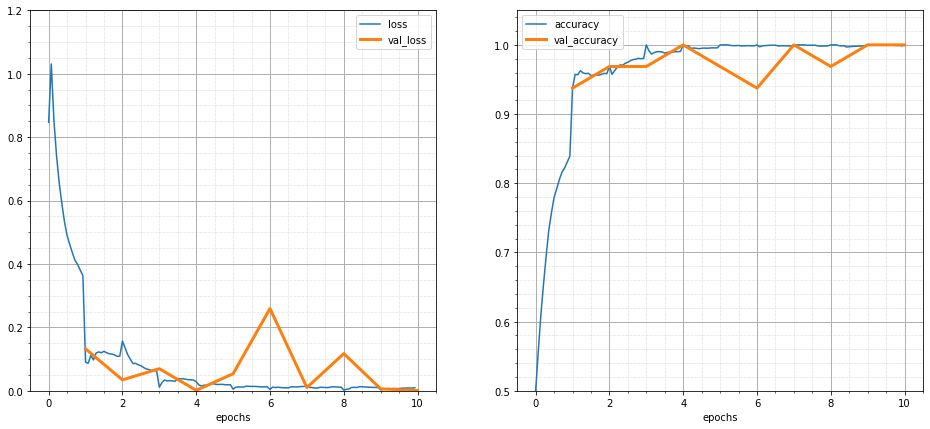

In [54]:
training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

ADDING ONE MORE LAYER

In [51]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(16, (5,5), padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(16, (3,3), padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),

  layers.Flatten(),

  layers.Dense(128),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_20 (Rescaling)     (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 160, 160, 16)      1216      
_________________________________________________________________
batch_normalization_60 (Batc (None, 160, 160, 16)      48        
_________________________________________________________________
activation_60 (Activation)   (None, 160, 160, 16)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 80, 80, 16)        2320      
_________________________________________________________________
batch_normalization_61 (Batc (None, 80, 80, 16)      

next filter


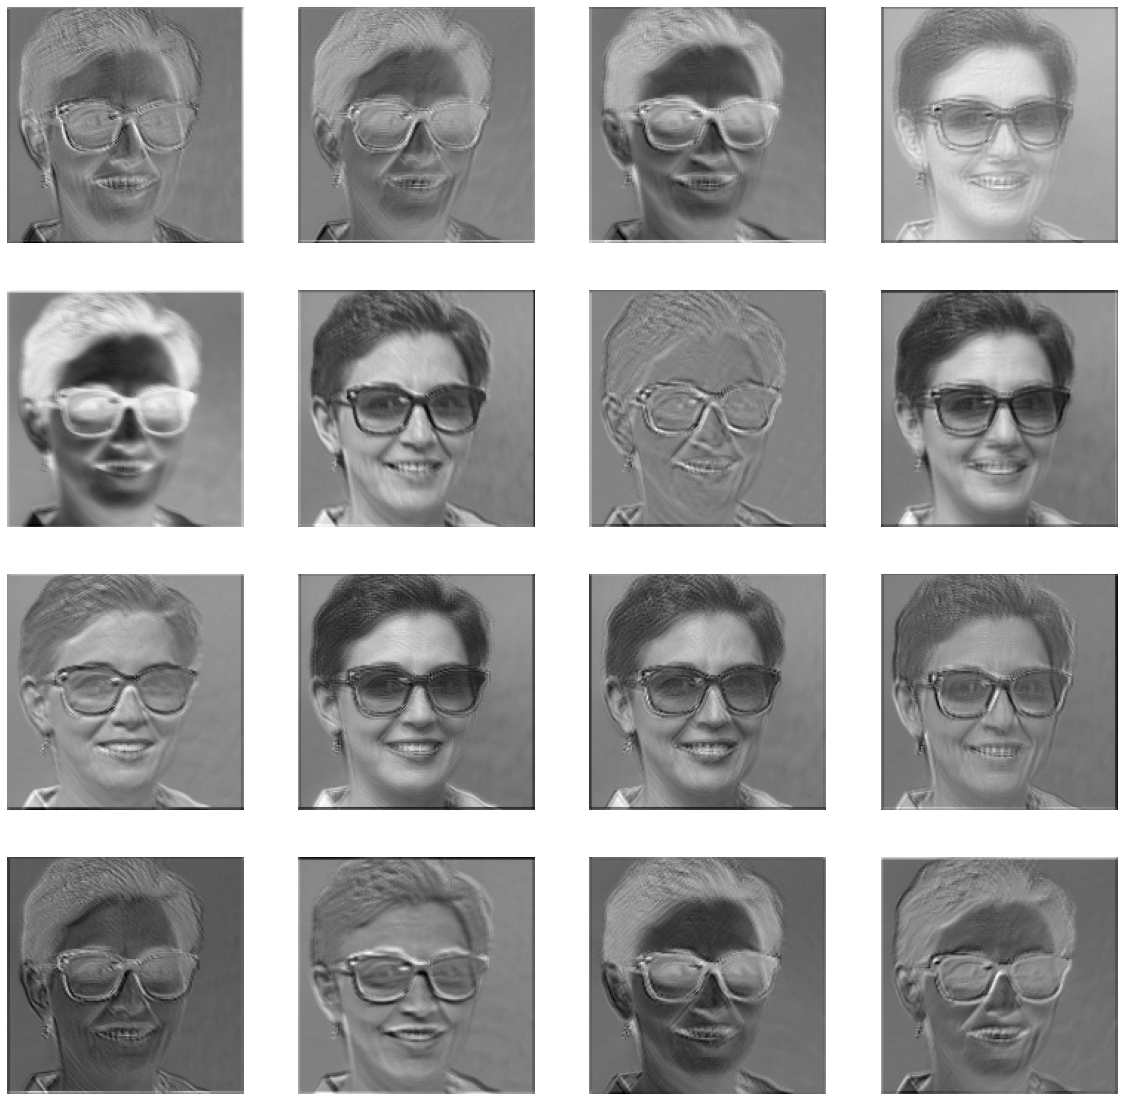

next filter


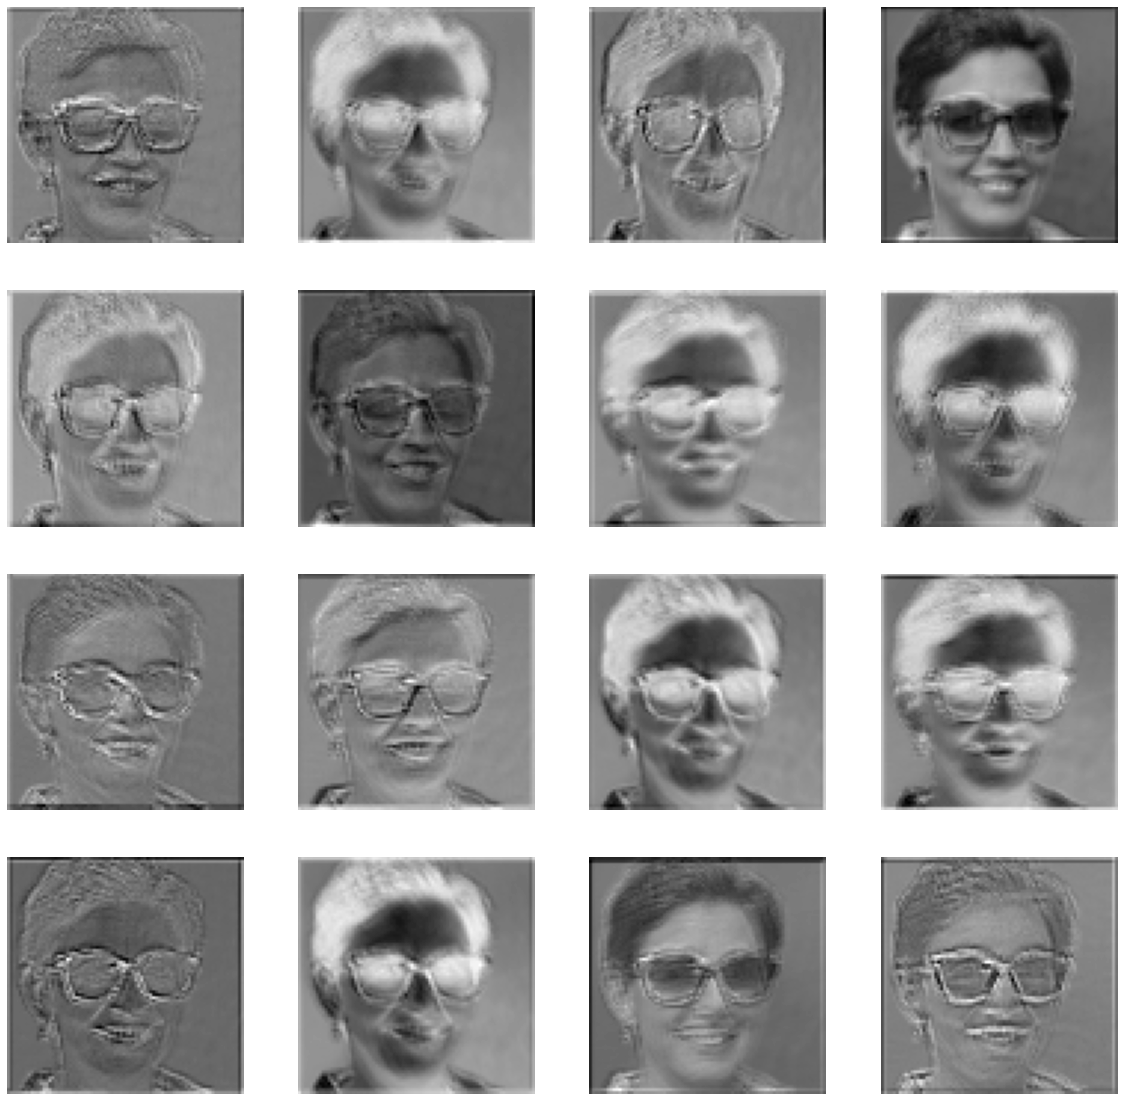

In [ ]:
#Print filters of the model

conv_list = [1, 5]
outputs = [model.layers[x].output for x in conv_list]

model_short = tf.keras.models.Model(inputs = model.inputs, outputs = outputs)

img = np.expand_dims(images.numpy()[np.where(labels.numpy() == 0)[0][0]], axis = 0)
feature_output = model_short.predict(img)

#plot filter output

columns = 4
rows = 4
n_filters = columns * rows

for ftr in feature_output:
  print("next filter")
  fig = plt.figure(figsize=(20, 20))

  for i in range(1, n_filters + 1):
    fig = plt.subplot(rows, columns, i)
    fig.axis('off')
    plt.imshow(ftr[0, :, :, i-1], cmap='gray')
  plt.show()

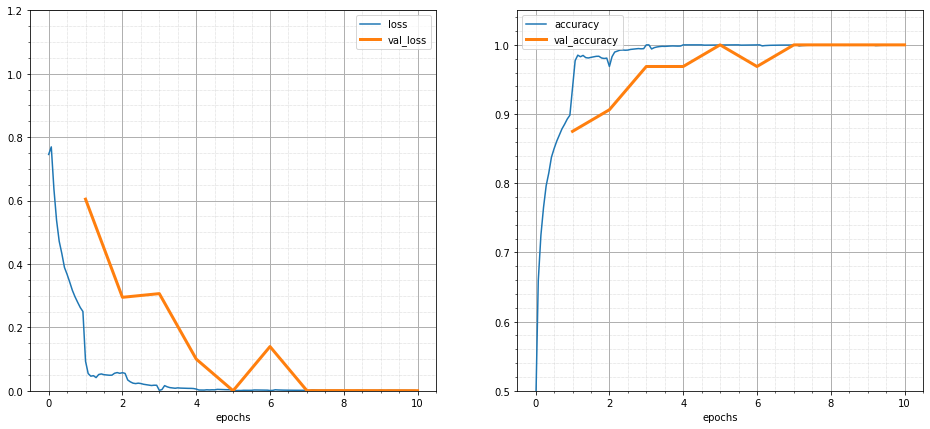

In [52]:
training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

ADDING DROPOUT

In [49]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

  layers.Conv2D(16, (5,5), padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(16, (3,3), padding='same',),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),

  layers.Dropout(0.32),

  layers.Flatten(),

  layers.Dense(128),
  layers.BatchNormalization(center=True, scale=False),
  layers.Activation('relu'),
  
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_19 (Rescaling)     (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 160, 160, 16)      1216      
_________________________________________________________________
batch_normalization_57 (Batc (None, 160, 160, 16)      48        
_________________________________________________________________
activation_57 (Activation)   (None, 160, 160, 16)      0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 80, 80, 16)        2320      
_________________________________________________________________
batch_normalization_58 (Batc (None, 80, 80, 16)      

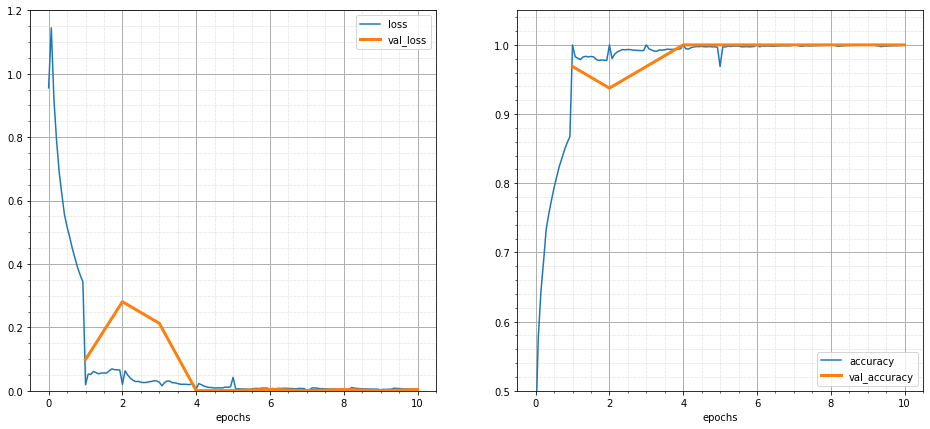

In [50]:
training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

TUNING HYPERPARAMETER: random search for tuning batch size and learning rate

In [35]:
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.01, 0.1]

best_accuracy = 0

best_batch = 0
best_lr = 0

# lr decay function
def lr_decay_0(epoch):
  return 0.001 * math.pow(0.6, epoch)
def lr_decay_1(epoch):
  return 0.01 * math.pow(0.6, epoch)
def lr_decay_2(epoch):
  return 0.1 * math.pow(0.6, epoch)


for batch in batch_sizes:
  BATCH_SIZE = batch

  for lr in learning_rates:

    model = tf.keras.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

        layers.Conv2D(16, (5,5), padding='same',),
        layers.BatchNormalization(center=True, scale=False),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(16, (3,3), padding='same',),
        layers.BatchNormalization(center=True, scale=False),
        layers.Activation('relu'),

        layers.Flatten(),

        layers.Dense(128),
        layers.BatchNormalization(center=True, scale=False),
        layers.Activation('relu'),
        
        layers.Dense(1, activation='sigmoid')
      ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    if lr == 0.001:
      lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay_0, verbose=True)
    elif lr == 0.01:
      lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay_1, verbose=True)
    elif lr == 0.1:
      lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay_2, verbose=True)
    
    training_dataset = get_training_ds()

    validation_dataset = get_validation_ds()

    history = model.fit(training_dataset,
                        steps_per_epoch=4500//BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=validation_dataset,
                        validation_steps=1,
                        callbacks=[lr_decay_callback])
    
    val_accuracy = history.history['val_accuracy'][6:]
    
    if sum(val_accuracy)/len(val_accuracy) > best_accuracy:
      best_accuracy = sum(val_accuracy)/len(val_accuracy)
      best_batch = batch
      best_lr = lr
    print("best")
    print(best_batch, best_lr)
    print("test")
    print(batch, lr)

print("best batch size is: " + str(best_batch))
print("best learning rate is: " + str(best_lr))
print("val_accuracy: " + str(best_accuracy))

Found 4469 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
140/140 [==============================] - 166s 116ms/step - loss: 0.1310 - accuracy: 0.9579 - val_loss: 0.6612 - val_accuracy: 0.4375
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.0006.
140/140 [==============================] - 14s 102ms/step - loss: 0.0204 - accuracy: 0.9957 - val_loss: 1.1642 - val_accuracy: 0.5000
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.00035999999999999997.
140/140 [==============================] - 14s 101ms/step - loss: 0.0082 - accuracy: 0.9989 - val_loss: 0.1982 - val_accuracy: 0.9688
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to 0.00021599999999999996.
140/140 [==============================] - 14s 100ms/step - loss: 0.0046 - accuracy: 0.9996 - val_loss: 0.0177 - val_accuracy: 1.0000
Epoch 5/10

Epoch 00005: Learni

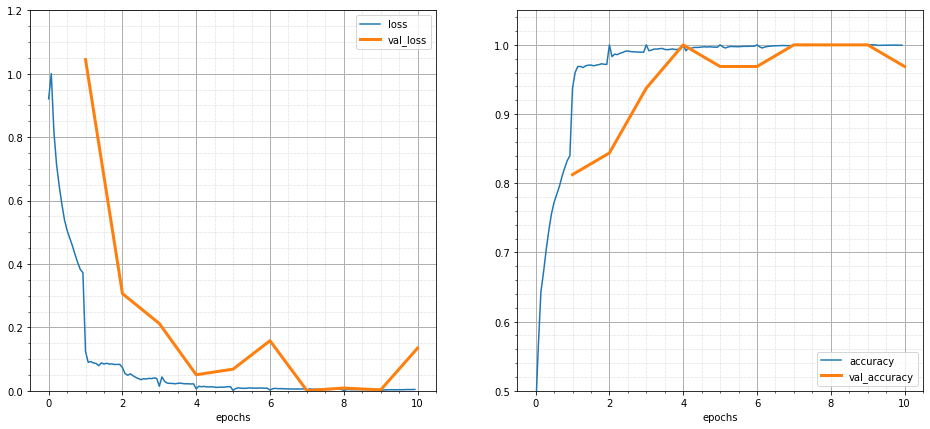

In [36]:
BATCH_SIZE = best_batch

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(160, 160, 3)),

    layers.Conv2D(16, (20,20), padding='same',),
    layers.BatchNormalization(center=True, scale=False),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(16, (5,5), padding='same',),
    layers.BatchNormalization(center=True, scale=False),
    layers.Activation('relu'),

    layers.Flatten(),

    layers.Dense(128),
    layers.BatchNormalization(center=True, scale=False),
    layers.Activation('relu'),
    
    layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss='binary_crossentropy',
                metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=10, zoom=1)

training_dataset = get_training_ds()

validation_dataset = get_validation_ds()

history = model.fit(training_dataset,
                    steps_per_epoch=4500//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])


VISUALIZATION OF THE PREDICTIONS

In [40]:
for validation_images, validation_labels in validation_dataset:
  validation_images = validation_images.numpy()
  validation_labels = validation_labels.numpy()
  break

In [41]:
predictions = model.predict(validation_images, steps = 1)
predicted_labels = list()

for pred in predictions:
  if pred[0] < 0.25:
    predicted_labels.append(0)
  else:
    predicted_labels.append(1)

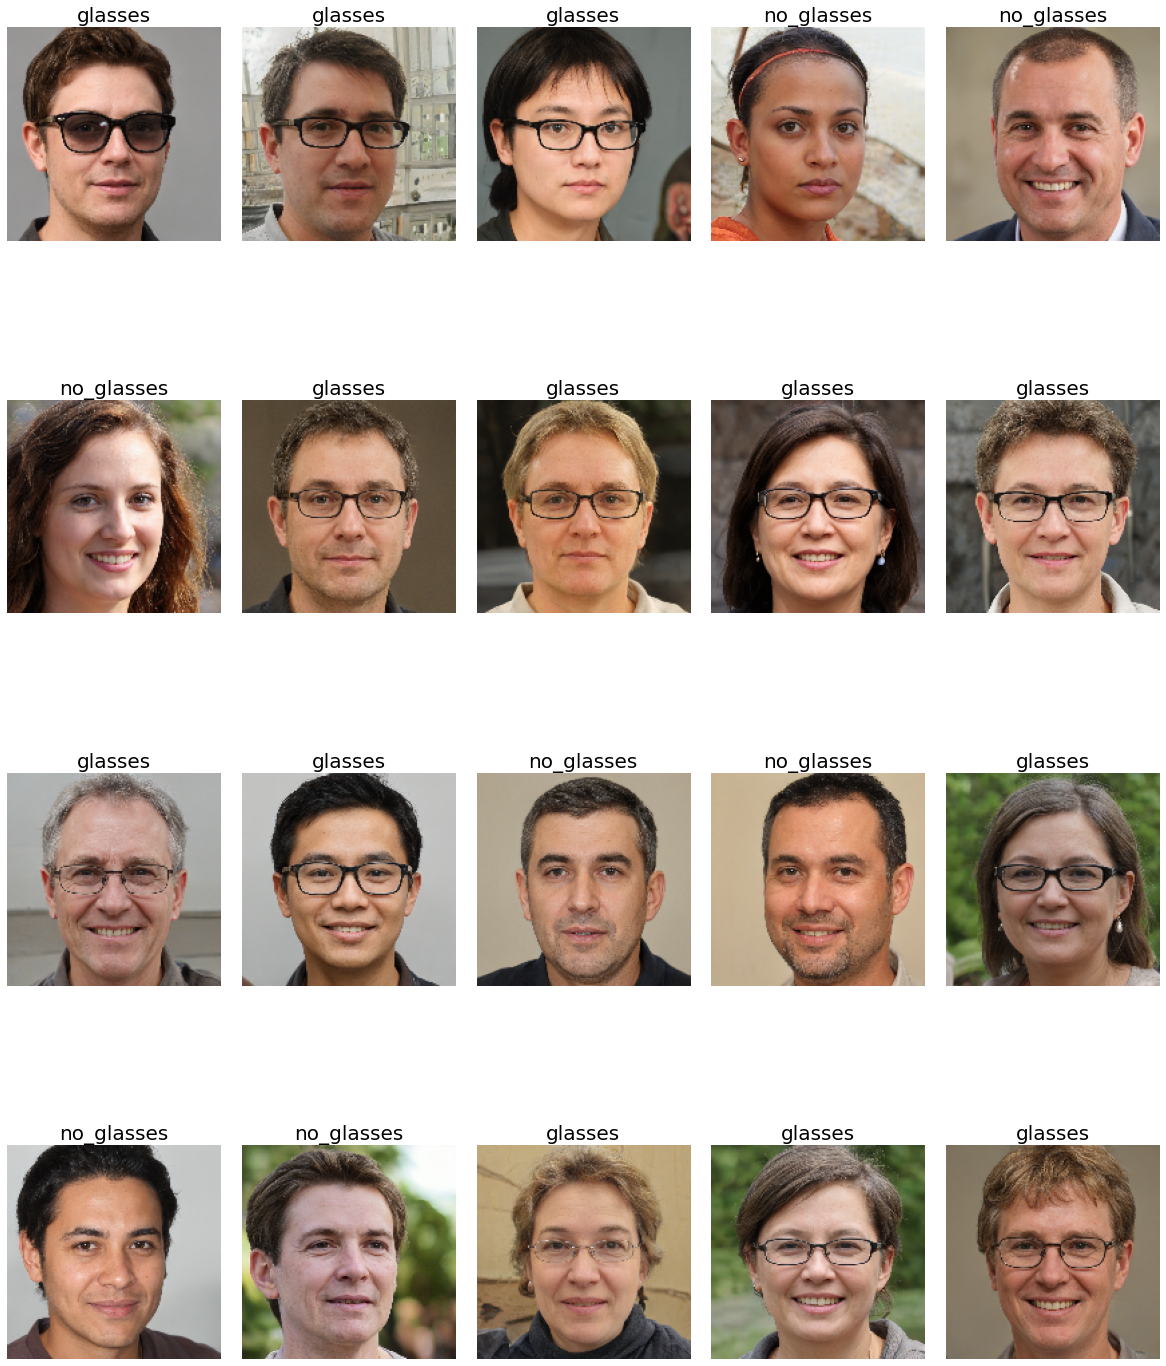

In [42]:
visualize_image(validation_images, predicted_labels, 20, validation_labels)

PREDICTION WITH A PICTURE OF MYSELF

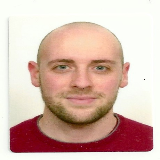

In [43]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/foto_tessera.jpeg")
res = cv2.resize(img, dsize=(160, 160))
cv2_imshow(res)
res = res.reshape(1, 160, 160, 3)

In [44]:
io = model.predict(res, steps = 1)

if io < 0.25:
  print("GLASSES")
else:
  print("NO GLASSES")

NO GLASSES
